In [ ]:
#Colab

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cvxpy as cp
from numpy import array, eye, hstack, ones, vstack, zeros
import copy
from cvxopt import matrix, solvers
import pandas as pd
solvers.options['show_progress'] = False

In [24]:
class soccer_game():
    
    def __init__(self, playerA, playerB):
        self.player1 = playerA
        self.player2 = playerB
        
        self.rows = 2
        self.columns = 4
        
        self.player1_goal = [0,4]
        self.player2_goal = [3,7]
        
        self.ball = np.random.randint(2) #0 or 1 at random
        
        self.ball_possession = playerA.pos
        
       
    def make(self, randomize = False):
        available_cells = [1,2,5,6]
        
        random_cell = np.random.choice(len(available_cells), 2, replace=False)
        
        if randomize:
            
            playerA.pos = available_cells[random_cell[0]]
            playerB.pos = available_cells[random_cell[1]]
            
            if np.random.randint(2)==0:
                self.ball = playerA.ball
                self.ball_possession = playerA.pos
            else:
                self.ball = playerB.ball
                self.ball_possession = playerB.pos
                
        else:
            
            playerA.pos = 2
            playerB.pos = 1
            self.ball = playerB.ball
            self.ball_possession = playerB.pos
            
    def move(self, player, action):
        
        if action == 0 and player.pos>3:
            new_loc = player.pos - 4
            
        elif action ==1 and player.pos not in self.player2_goal:
            new_loc = player.pos + 1
            
        elif action == 2 and player.pos<4:
            new_loc = player.pos + 4
            
        elif action == 3 and player.pos not in self.player1_goal:
            new_loc = player.pos - 1
            
        else:
            new_loc = player.pos
            
        return new_loc
        
    def actions(self, player1, player2, action1, action2):
        new_loc1 = self.move(player1, action1)
        new_loc2 = self.move(player2, action2)
        
        if new_loc1 != player2.pos: #Always player1 moves first
            player1.pos = new_loc1 #moving to the available cell
        else:
            self.ball = player2.ball #Ball moves to opponent if the cell is occupied
            
        if new_loc2 != player1.pos:
            player2.pos = new_loc2
        else:
            self.ball = player1.ball
            
        if self.ball:                              
            self.ball_possession = player1.pos
        else:
            self.ball_possession = player2.pos
            
    def step(self, action1, action2):
        
        p1 = self.player1
        p2 = self.player2
        
        if np.random.randint(2)==0:
            self.actions(p1, p2, action1, action2)
        else:
            self.actions(p2, p1, action2, action1)
            
        if self.ball_possession in self.player1_goal:
            reward_1 = 100
            reward_2 = -100
            end = 1
            #print("Goal by PlayerA!")
        
        elif self.ball_possession in self.player2_goal:
            reward_1 = -100
            reward_2 = 100
            end = 1
            #print("Goal by PlayerB!")
            
        else:
            reward_1 = 0
            reward_2 = 0
            end = 0
            
        return self.state(), reward_1, reward_2, end
    
    def state(self):
        return [playerA.pos, playerB.pos, env.ball]


class player():

    def __init__(self, name="", ball = None):
        self.name = name
        self.score = 0
        self.pos = 0
        self.ball = ball
        print("Player {} Created".format(name))


In [25]:
import matplotlib
def graph_error(error_list, iter_list, name="Q Learning", linewidth = 1):
    plt.figure(figsize=[8,8])
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    plt.plot(iter_list, error_list, linewidth = linewidth)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(name)
    plt.xlabel('Iteration')
    plt.ylim(0, 0.5)
    plt.ylabel('Q Value Difference')
    plt.show()
    plt.gcf().clear()

In [ ]:
def solve_LP(mat):

  A = copy.copy(mat.T)
  #A = copy.copy(mat)
        
  I = np.zeros((5, 5))

  for ww in range(5):
    I[ww, ww] = 1
        
  A = np.vstack((A, I))
  A = np.hstack(
            (A, [[-1], [-1], [-1], [-1], [-1], [0], [0], [0], [0], [0]]))
    
  A = np.vstack(
            (A, [1, 1, 1, 1, 1, 0], [-1, -1, -1, -1, -1, 0]))
    
  b = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., -1.])
    
    
  c = np.array([0., 0., 0., 0., 0., 1.])
        
  #print("Hit 2")
    
  x = cp.Variable(5+1)
    
  prob = cp.Problem(cp.Minimize(-c.T@ x),[-A @ x <= -b])
    
  v_value = prob.solve()

  #print (v_value)
        
    
  x_value = x.value

  return x_value, v_value


In [26]:
def max_min(Q):
    c = matrix([-1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    G = matrix(np.append(np.append(np.ones((5,1)), -Q.T, axis=1), np.append(np.zeros((5,1)), -np.eye(5), axis=1), axis=0))
    h = matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    A = matrix([[0.0],[1.0], [1.0], [1.0], [1.0], [1.0]])
    b = matrix(1.0)
    sol = solvers.lp(c=c, G=G, h=h, A=A, b=b)
    return np.abs(sol['x'][1:]).reshape((5,)) / sum(np.abs(sol['x'][1:])), np.array(sol['x'][0])

In [27]:
def FoeQ_FoeQ(env, playerA, playerB, start_randomize = False, greenwald_off_policy = False, epsilon = 1.0, alpha = 1.0):
    
    #Greenwalds Off policy definition is different than Sutton's
    
    itt = 1000000 #from figure 3
    t_start = time.time()
    
    ep = 1.0
    ep_min = 0.001
    ep_decay = 10**(np.log10(ep_min)/itt)
    
    alpha = 0.9
    alpha_min = 0.001
    alpha_decay = 10**(np.log10(ep_min)/itt)
    
    gamma = 0.9
    
    Qa = np.ones([8, 8, 2, 5, 5])
    Va = np.ones([8,8,2])

    pi_a = np.ones([8,8,2,5])/5

    Qb = np.ones([8, 8, 2, 5, 5])
    Vb = np.ones([8,8,2])

    pi_b = np.ones([8,8,2,5])/5

    
    env.make(start_randomize)
    end = 0
    
    error = []
    seq = []
    won = 0
    lost = 0
    wr = 0
    result = []
    
    numActions = 5
    
    for i in range(itt):
        
        if end == 1:
            env.make(start_randomize)
            
        pA = playerA.pos
        pB = playerB.pos
        ball = env.ball
        
        old_q_val = Qa[2,1,1,2,4]
 
        if ep > np.random.random():
            
            actA = np.random.choice(5) #5 actions

        else:
            actA = np.random.choice(np.arange(5),1,p=pi_a[pA,pB,ball]) #randomly choose an action according to policy pi_a

        if ep > np.random.random():

            actB = np.random.choice(5)
            
        else:

            actB = np.random.choice(np.arange(5),1,p=pi_b[pA,pB,ball])
            
        next_state, rewardA, rewardB, end = env.step(action1 = actA, action2 = actB)
        na, nb, nball = next_state
        
        #next_Q = Qa[na, nb, nball]
        #print("Hit 1")

        current_Q_a = Qa[playerA.pos, playerB.pos, env.ball]
        current_Q_b = Qb[playerA.pos, playerB.pos, env.ball]
        
        xa_temp,va_temp = max_min(current_Q_a)
        #xa_temp = xa_temp[1:]
        #xa_temp[np.where(xa_temp<0)] = 0
        #xa_temp = np.abs(xa_temp) / sum(np.abs(xa_temp))

        xb_temp,vb_temp = max_min(current_Q_b)
        #xb_temp = xb_temp[1:]
        #xb_temp[np.where(xb_temp<0)] = 0
        #xb_temp = np.abs(xb_temp) / sum(np.abs(xb_temp))
        
        Va[playerA.pos, playerB.pos, env.ball] = va_temp
        Vb[playerA.pos, playerB.pos, env.ball] = vb_temp

        pi_a[playerA.pos, playerB.pos, env.ball] = xa_temp
        pi_b[playerA.pos, playerB.pos, env.ball] = xb_temp

       
        if end == 1:
            Qa[pA,pB,ball,actA, actB] = (1-alpha) *Qa[pA,pB,ball,actA, actB] + alpha*(1-gamma)*rewardA
            Qb[pA,pB,ball,actA, actB] = (1-alpha) *Qb[pA,pB,ball,actA, actB] + alpha*(1-gamma)*rewardB

            if rewardA == 100:
              won += 1
            else:
              lost += 1

        else:
            #print("Hit 4")
            Qa[pA,pB,ball,actA, actB] = (1-alpha) *Qa[pA,pB,ball,actA, actB] + alpha*((1-gamma)*rewardA + gamma *Va[na, nb, nball])
            Qb[pA,pB,ball,actA, actB] = (1-alpha) *Qb[pA,pB,ball,actA, actB] + alpha*((1-gamma)*rewardB + gamma *Vb[na, nb, nball])
            
        #print(Qa[2,1,1,2,4])

        if [pA,pB,ball,actA] == [2,1,1,2,4] or i%1 == 0:
            err = abs(Qa[2,1,1,2,4] - old_q_val)

            if lost == 0  and won == 0:
              wr = 0

            else:
              wr = won/(won+lost)*100

            result.append([i,err,wr, alpha, ep])
            print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f} \t Epsilon: {:.3f} \t Err: {:.3f} \t Win_Rate: {:.3f}'.format(i, time.time() - t_start, i*100/itt, alpha, ep,err,wr), end="")


        if greenwald_off_policy == False:
            ep *= ep_decay
            ep = max(ep_min, ep)
        
        alpha *= alpha_decay
        alpha = max(alpha_min, alpha)

        #alpha = 1 / (i / alpha_min / itt + 1)
  

    return result, Qa, Qb, pi_a, pi_b

In [28]:
playerA = player(name="A", ball = 0)
playerB = player(name="B", ball = 1)
env = soccer_game(playerA, playerB)

Player A Created
Player B Created


In [29]:
#a=0.9
Result, Qa, Qb, pi_a, pi_b = FoeQ_FoeQ(env, playerA, playerB, start_randomize = False, greenwald_off_policy = False, epsilon = 1.0, alpha = 1.0)

step 999999	 Time: 2372.32 	 Percentage: 100.00% 	 Alpha: 0.001 	 Epsilon: 0.001 	 Err: 0.000 	 Win_Rate: 47.364

In [19]:
df = pd.DataFrame(Result, columns = ["Itteration","Error", "WinRate", "Alpha", "Epsilon"])

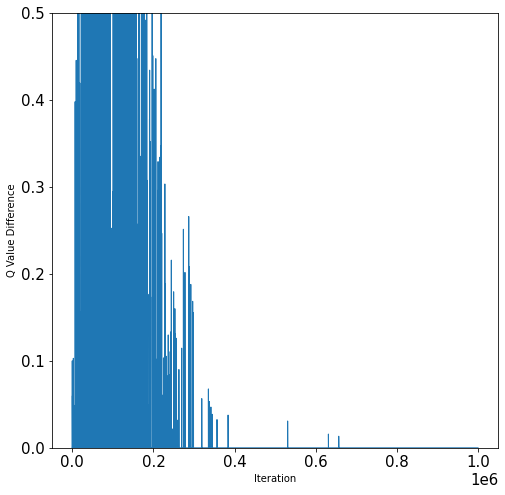

<Figure size 432x288 with 0 Axes>

In [30]:
graph_error(df["Error"], df["Itteration"], name="", linewidth = 1)

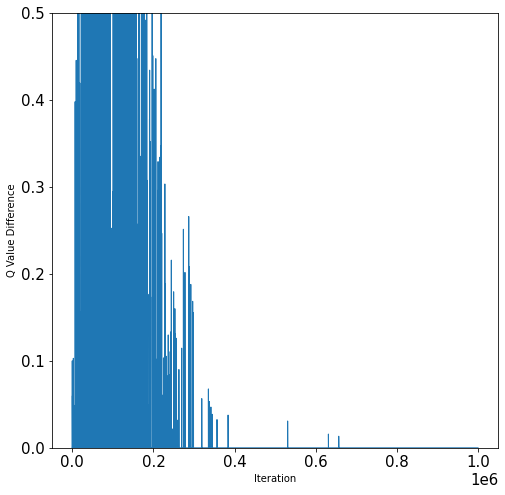

<Figure size 432x288 with 0 Axes>

In [20]:
#graph of alpha=1
#graph_error(df["Error"], df["Itteration"], name="", linewidth = 1)

In [22]:
for item in Qa[2,1,1]:
    for ele in item:
 
        # print in a single line
        print('\t {:.6f}'.format(ele), end= " ")
    print()

	 -0.220460 	 -0.031152 	 -0.817006 	 6.258859 	 -0.259091 
	 -7.580495 	 -10.000000 	 -7.870829 	 -1.658768 	 -6.987844 
	 -2.351630 	 -2.709634 	 -2.428078 	 8.200364 	 -2.666224 
	 -0.059818 	 -0.033214 	 1.722786 	 6.951581 	 -0.055415 
	 -0.034433 	 -0.031260 	 -0.409763 	 7.324032 	 -0.034609 


In [31]:
for item in Qa[2,1,1]:
    for ele in item:
 
        # print in a single line
        print('\t {:.6f}'.format(ele), end= " ")
    print()

	 -0.253391 	 -0.000027 	 -0.948960 	 6.574696 	 -0.312173 
	 -6.913020 	 -10.000000 	 -8.224727 	 2.129867 	 -7.104250 
	 3.559446 	 -4.286664 	 -0.298004 	 6.817520 	 3.690295 
	 -0.000026 	 -0.000023 	 1.867019 	 7.243298 	 -0.000026 
	 -0.122070 	 -0.000027 	 -0.380358 	 7.044792 	 -0.181208 
